In [1]:
import tensorflow as tf
import h5py # pip3 install h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the mnist pre-shuffled train data and test data: RUNTERGUCKEN
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


The cell above contains the usual "magic": it imports certain libraries that allow to use OS functionalities, plotting and most importantly the TensorFlow library.

It also downloads the dataset and we look at the "shape", that is: how many samples, how are they stored.

That's a 3


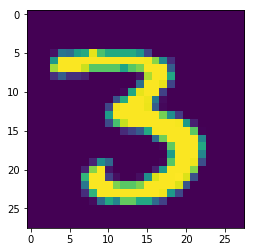

In [2]:
index = 12
plt.imshow(x_train[index])
print("That's a " + str(y_train[index]))

In [3]:
x_train[index]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  12,  99,  91, 142, 155, 246, 182, 155, 155, 155,
        155, 131,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

Now we have to reshape the data. First, we take some more picture and put them into a special validation set which is not used during training.

Then we have to change the form of the data a little bit, but that's just for technical reasons.

In [4]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


Now comes the magic: we build the neural network. It consists of a few convolution layers with maxpool and a couple of dense (aka "normal") layers in between. That's a big network!

In [5]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 32)          1056      
__________

We can quickly set up what kind of error ("loss") function we want and what specific optimization we use. ADAM is similar to our gradient descent from before, but it's adaptive! So it changes its stride in a clever way according to the way the error changes.

In [6]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

This is also pretty nifty: we use the training and validation data from before to train our model. Caution: each epoch takes about 1.5 minutes! But then we save the best model measured from the accuracy on the validation data.

In [7]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 0, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=2,
         epochs=15,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 179s 3ms/step - loss: 14.5565 - acc: 0.0966 - val_loss: 14.3935 - val_acc: 0.1070
Epoch 2/15
55000/55000 [==============================] - 194s 4ms/step - loss: 14.5628 - acc: 0.0965 - val_loss: 14.3935 - val_acc: 0.1070
Epoch 3/15
55000/55000 [==============================] - 188s 3ms/step - loss: 14.5628 - acc: 0.0965 - val_loss: 14.3935 - val_acc: 0.1070
Epoch 4/15
47900/55000 [=========================>....] - ETA: 24s - loss: 14.5625 - acc: 0.0965

KeyboardInterrupt: 

We load that best model into memory..

In [ ]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

And validate it against the test data (test isn't validation)!

In [ ]:
#Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])

Let's look at some random samples and check if the model predicted them correctly.

In [ ]:
y_hat = model.predict(x_test)

figure = plt.figure(figsize=(20, 10))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    
    ax.set_title("{} ({})".format(predict_index, true_index),
                 color=("green" if predict_index == true_index else "red"))

